# Conversion Rate Analysis and Prediction
## Author: Ning Zhang
## Date: June 16, 2021

### Background: 
The data was given is a conversion or not user-level data. 

### Goal of the task:
- Predict conversion rate
- Come up with recommendations for the product team and the marketing team to improve conversion rate

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [2]:
### Part I: Read and Observe the data
df = pd.read_csv('conversion_project.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
# check the description and column type
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
# check whether any missing
df.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

Key observation:
- age has a max of 123, which seems to be an outlier
- new user stands for 68% of entire population
- mean conversion rate is 3%

### Part II: data processing and feature analysis

In [7]:
# remove age outliers.# typically users with age greater than 80 are very rare.Lets find out how many of them, and remove it
df = df.loc[df.age<=80]
# two records are removed.

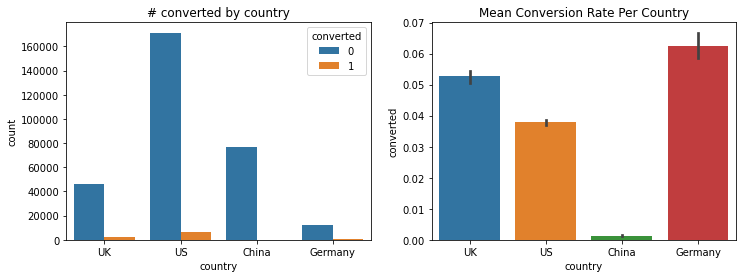

In [9]:
# check conversion rate by country, using countplot and barplot here
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
sns.countplot(x = 'country', hue = 'converted', data = df, ax = ax[0])
ax[0].set_title('# converted by country')
sns.barplot(x = 'country', y = 'converted', data = df, ax = ax[1])
ax[1].set_title('Mean Conversion Rate Per Country')
plt.show()

Key observation:
- China has a very low conversion rate
- Germany has the highest conversion rate

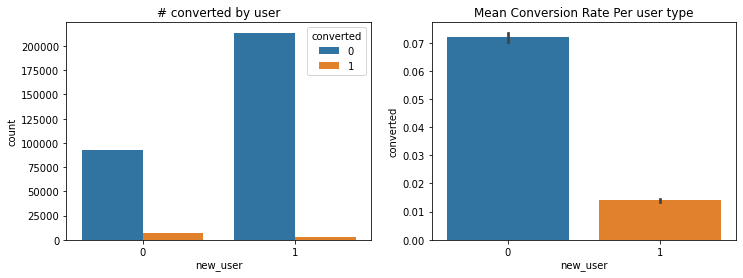

In [11]:
# check conversion rate by user type
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
sns.countplot(x = 'new_user', hue = 'converted', data = df, ax = ax[0])
ax[0].set_title('# converted by user')
sns.barplot(x = 'new_user', y = 'converted', data = df, ax = ax[1])
ax[1].set_title('Mean Conversion Rate Per user type')
plt.show()

Key observation:
- New user seems to have very low conversion rate

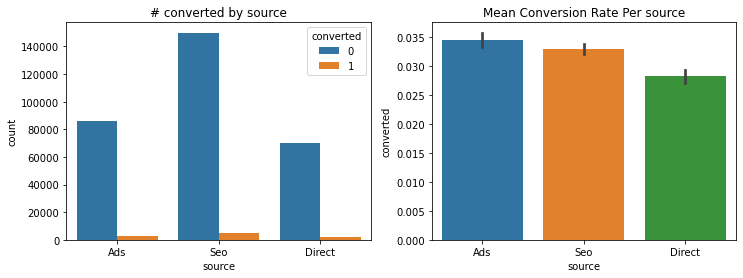

In [12]:
# check conversion rate by source
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
sns.countplot(x = 'source', hue = 'converted', data = df, ax = ax[0])
ax[0].set_title('# converted by source')
sns.barplot(x = 'source', y = 'converted', data = df, ax = ax[1])
ax[1].set_title('Mean Conversion Rate Per source')
plt.show()

Key observation:
- Not too big difference among different sources, while ads has the highest conversion rate

C:\Users\journ\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\journ\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


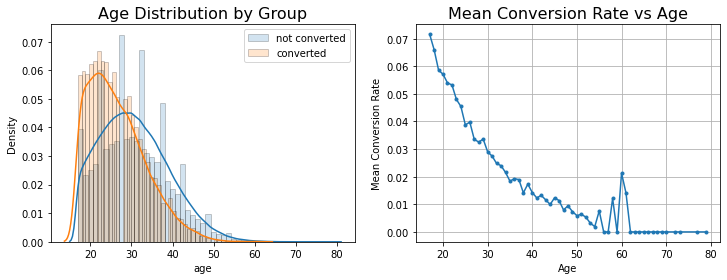

In [13]:
# check conversion rate by age
con_age = df[['age','converted']].groupby('age').mean().reset_index()
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (12,4))
sns.distplot(df[df.converted==0]['age'],label = 'not converted', ax = ax[0], hist_kws = hist_kws)
sns.distplot(df[df.converted==1]['age'],label = 'converted', ax = ax[0], hist_kws = hist_kws)
ax[0].set_title('Age Distribution by Group', fontsize=16)
ax[0].legend()

ax[1].plot(con_age['age'], con_age['converted'],'.-')
ax[1].set_title('Mean Conversion Rate vs Age', fontsize = 16)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Mean Conversion Rate')
ax[1].grid(True)
plt.show()

Key observation:
- in coverted group, the overall age is yonger than non-converted group. This may indicate that yonger age clients may have higher chance to get converted
- The mean conversion rate decreases from age 20 to 55, but see a increase from age 55 - 62. People older than ~62 have almost 0 conversion.

C:\Users\journ\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\journ\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


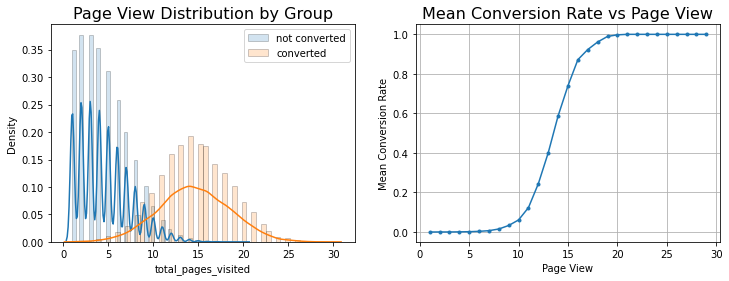

In [16]:
# check conversion by page views:
con_page = df[['total_pages_visited','converted']].groupby('total_pages_visited').mean().reset_index()
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (12,4))
sns.distplot(df[df.converted==0]['total_pages_visited'],label = 'not converted', ax = ax[0], hist_kws = hist_kws)
sns.distplot(df[df.converted==1]['total_pages_visited'],label = 'converted', ax = ax[0], hist_kws = hist_kws)
ax[0].set_title('Page View Distribution by Group', fontsize=16)
ax[0].legend()

ax[1].plot(con_page['total_pages_visited'], con_page['converted'],'.-')
ax[1].set_title('Mean Conversion Rate vs Page View', fontsize = 16)
ax[1].set_xlabel('Page View')
ax[1].set_ylabel('Mean Conversion Rate')
ax[1].grid(True)
plt.show()

Key Observations:
- After reading 20 pages, almost all users will be converted.

### Part III: Random Forest Model to predict conversion date

In [18]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 49 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_journ_7eomld
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.880 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [19]:
# We decided to incorporate all features into the model:
- new_user, age, page visited, country, source

In [20]:
h2o_df = H2OFrame(df)
# transform categorical factors
h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [22]:
h2o_df.summary()

,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.5693110013347,,,4.872918234777034,
maxs,,79.0,,,29.0,
sigma,,8.268957596421474,,,3.3410533442156267,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [27]:
df2 = h2o_df['converted'].stratified_split(test_frac = 0.25, seed = 42)
train = h2o_df[df2 == 'train']
test = h2o_df[df2 == 'test']
feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [29]:
rf = H2ORandomForestEstimator(balance_classes = True, ntrees = 100, max_depth = 20, mtries = -1, seed = 42, score_each_iteration = True)
rf.train(x = feature, y = target, training_frame = train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


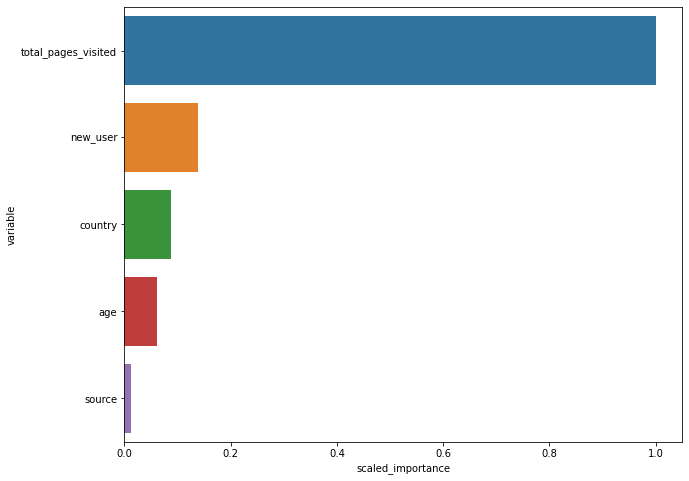

In [31]:
fea_importance = rf.varimp(use_pandas = True)
fig, ax = plt.subplots(figsize = (10, 8))
sns.barplot(x = 'scaled_importance', y = 'variable', data = fea_importance)
plt.show()

In [34]:
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_p = rf.predict(train).as_data_frame()['p1'].values
test_p = rf.predict(test).as_data_frame()['p1'].values

train_fp, train_tp,_ = roc_curve(train_true, train_p)
test_fp, test_tp,_ = roc_curve(test_true, test_p)
train_auc = np.round(auc(train_fp, train_tp),3)
test_auc = np.round(auc(test_fp,test_tp),3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [36]:
# Classification report
print(classification_report(y_true = test_true, y_pred = (test_p > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76500
           1       0.84      0.63      0.72      2550

    accuracy                           0.98     79050
   macro avg       0.91      0.81      0.86     79050
weighted avg       0.98      0.98      0.98     79050



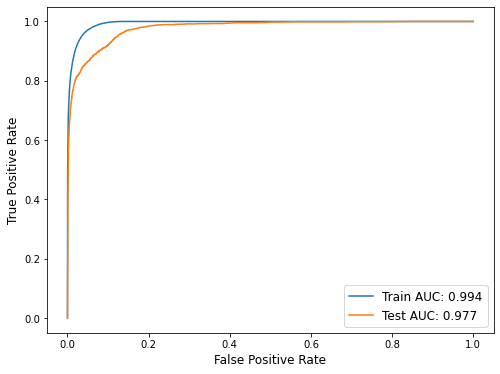

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fp, train_tp, label='Train AUC: ' + str(train_auc))
ax.plot(test_fp, test_tp, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


C:\Users\journ\anaconda3\lib\site-packages\h2o\model\model_base.py:1391: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [0 1 2 3] in fill_betweenx(). This will become an error two minor releases later.
  axs.fill_between(x, lower, upper, where=lower < upper, alpha=0.1, interpolate=False)
C:\Users\journ\anaconda3\lib\site-packages\h2o\model\model_base.py:1391: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [17.0 20.263157894736842 23.526315789473685 26.789473684210527
 30.05263157894737 33.315789473684205 36.578947368421055 39.84210526315789
 43.10526315789474 46.368421052631575 49.63157894736842 52.89473684210526
 56.1578947368421 59.421052631578945 62.68421052631579 65.94736842105263
 69.21052631578948 72.47368421052632 75.73684210526315 79.0] in fill_betweenx(). This will become an error two minor releases later.
  axs.fill_between(x, lower, upper, where=lower < upper, alpha=0.1, interpolate=False)


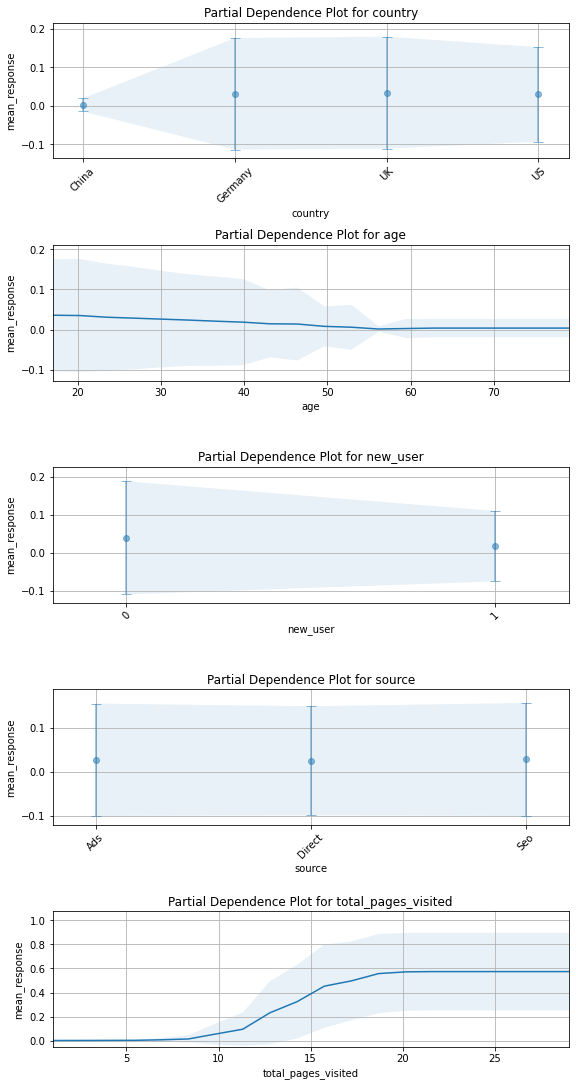

In [40]:
_ = rf.partial_plot(train, cols=feature, figsize=(8, 15))

### Part IV: Sklearn Random Forest


In [64]:
# one hot encoding
feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
fea1 = df[feature]
fea1 = pd.get_dummies(fea1)
fea1

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
316195,26,1,9,0,0,0,1,1,0,0
316196,27,1,6,0,0,0,1,0,1,0
316197,25,0,4,1,0,0,0,1,0,0
316198,22,0,4,0,0,0,1,0,0,1


In [43]:
target = np.array(df['converted'])
fea = np.array(fea)

In [47]:
X_train, X_test, y_train,y_test = train_test_split(fea, target, test_size = 0.25, random_state = 42)

In [50]:
# fit model
rf2 = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth = 20)
rf2.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=42)

In [57]:
# confusion matrix
ypred = rf2.predict(X_test)
# Confusion matrix: tells us Type I and Type II errors. 
print(classification_report(y_true = y_test, y_pred = (ypred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     76553
           1       0.81      0.69      0.74      2497

    accuracy                           0.99     79050
   macro avg       0.90      0.84      0.87     79050
weighted avg       0.98      0.99      0.98     79050



In [60]:
print(roc_auc_score(y_test,rf2.predict_proba(X_test)[:, 1]))

0.9532846467084422


In [65]:
# variable importance
# Get numerical feature importances
importances = list(rf2.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(f, round(importance, 2)) for f, importance in zip(fea1.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: total_pages_visited  Importance: 0.81
Variable: age                  Importance: 0.11
Variable: new_user             Importance: 0.04
Variable: country_China        Importance: 0.02
Variable: country_Germany      Importance: 0.0
Variable: country_UK           Importance: 0.0
Variable: country_US           Importance: 0.0
Variable: source_Ads           Importance: 0.0
Variable: source_Direct        Importance: 0.0
Variable: source_Seo           Importance: 0.0


[None, None, None, None, None, None, None, None, None, None]

In [66]:
feature_importances

[('total_pages_visited', 0.81),
 ('age', 0.11),
 ('new_user', 0.04),
 ('country_China', 0.02),
 ('country_Germany', 0.0),
 ('country_UK', 0.0),
 ('country_US', 0.0),
 ('source_Ads', 0.0),
 ('source_Direct', 0.0),
 ('source_Seo', 0.0)]

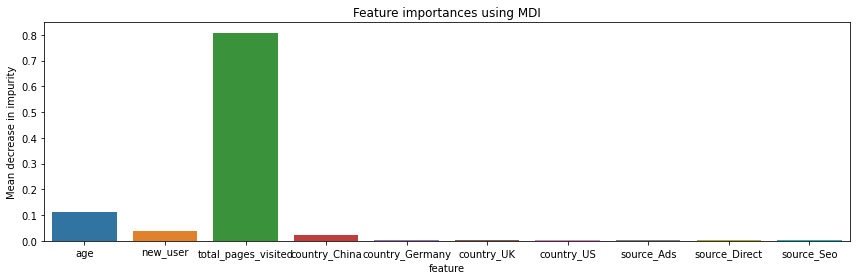

In [74]:
forest_importances = pd.DataFrame(importances, index=fea1.columns).reset_index()
forest_importances.rename(columns={"index": "feature", 0: "importance"}, inplace = True)
forest_importances
fig, ax = plt.subplots(figsize = (12,4))
sns.barplot(x = 'feature', y = 'importance', data = forest_importances, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Part V: Logistic Regression

In [77]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('The model intercept is', lr.intercept_)
print('The model coefficient is', lr.coef_)

C:\Users\journ\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The model intercept is [-5.04428066]
The model coefficient is [[-0.07466556 -1.74171969  0.76047793 -3.78252594 -0.0093834  -0.21168334
  -0.59650515 -1.47693366 -1.64272941 -1.48043476]]


In [78]:
# confusion matrix
ypred = lr.predict(X_test)
# Confusion matrix: tells us Type I and Type II errors. 
print(classification_report(y_true = y_test, y_pred = (ypred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76553
           1       0.86      0.70      0.77      2497

    accuracy                           0.99     79050
   macro avg       0.92      0.85      0.88     79050
weighted avg       0.99      0.99      0.99     79050



In [79]:
print(roc_auc_score(y_test,lr.predict_proba(X_test)[:, 1]))

0.986260042036205


In [81]:
feat_importances = pd.DataFrame({"name":fea1.columns,"coef":lr.coef_[0]})
feat_importances = feat_importances[['name','coef']]# reorder the columns
feat_importances['importances'] = np.abs(feat_importances['coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances

,name,coef,importances
3,country_China,-3.782526,3.782526
1,new_user,-1.741720,1.741720
8,source_Direct,-1.642729,1.642729
9,source_Seo,-1.480435,1.480435
7,source_Ads,-1.476934,1.476934
2,total_pages_visited,0.760478,0.760478
6,country_US,-0.596505,0.596505
5,country_UK,-0.211683,0.211683
0,age,-0.074666,0.074666
4,country_Germany,-0.009383,0.009383


In [82]:
h2o.cluster().shutdown()

H2O session _sid_af94 closed.
